In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score
from sklearn import mixture, preprocessing, datasets

from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches

import torch.utils.data as data_utils

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

import model_paths

This notebook finds the best attack samples for a given dataset, using the statistics collecting in **gen_attack_stats.py**. In the file_dict below one has to specify the path name of the saved results, one wishes to select from.
The output is a sample for each model in **model_paths.py**. All samples in a row are generated from the same seed.

In [29]:
dataset = 'CIFAR100'

file_dict = {'MNIST' :'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_MNIST_2019-06-15 09:35:00.029096_MNIST.pth',
             'FMNIST':'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_FMNIST_2019-06-11 08:05:12.188177_FMNIST.pth',
             'SVHN' : 'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_SVHN_2019-06-15 06:39:42.380228_SVHN.pth',
             'CIFAR10':'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_CIFAR10_2019-06-15 06:40:05.851630_CIFAR10.pth',
             'CIFAR100' : 'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_CIFAR100_2019-06-15 06:41:07.390466_CIFAR100.pth'
            }

file = file_dict[dataset]

batch = torch.load('results/backup/' + file)

model_params = params.params_dict[dataset]()
model_path = model_paths.model_dict[dataset]() 
model_list = [torch.load(file).cpu().eval() for file in list(model_path.file_dict.values())]

Using downloaded and verified file: ../data/test_32x32.mat


In [30]:
num_of_models = len(model_list)

if dataset in ['MNIST', 'FMNIST']:
    noise = batch.samples.transpose(0,1).contiguous().view(num_of_models, 1000, 1, 28, 28)
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    noise = batch.samples.transpose(0,1).contiguous().view(num_of_models, 1000, 3, 32, 32)
    
noise_list = []
for i in range(num_of_models):
    noise_list.append(noise[i])

In [31]:
Y = [model(no).max(1) for (no, model) in zip(noise_list, model_list)]
conf = [y[0][0].exp().item() for y in Y]
pred = [y[1][0].item() for y in Y]

In [32]:
conf = torch.stack([y[0] for y in Y], 0)
index = conf.exp().sum(0).argmax()
#index = 10

if dataset in ['MNIST', 'FMNIST']:
    seed = batch.seeds.view(-1,1,28,28)[index]
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    seed = batch.seeds.view(-1,3,32,32)[index]

adv_noise = noise[:,index]

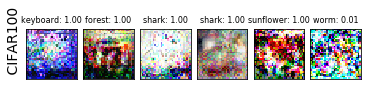

In [35]:
#plt.subplot(1, num_of_models, 1)
#plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
#          fontsize=14, position=(0,0))

#if dataset in ['MNIST', 'FMNIST']:
#    plt.imshow(seed.squeeze().detach().cpu(), cmap='gray', interpolation='none')
#elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
#    plt.imshow(seed.transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')

#plt.xticks([])
#plt.yticks([])

for i in range(num_of_models):
    plt.subplot(1, num_of_models, 1 + i)
    if i==0:
        plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
                   fontsize=14, position=(0,0))
        
    if dataset in ['MNIST', 'SVHN']:
        string = list(model_path.file_dict.keys())[i] + '\n'
    else:
        string = ''

    string += ( str(plotting.classes_dict[dataset][pred[i]] )
               + ": %.2f" % conf[i][index].exp().item() )

    plt.title(string, fontsize=8)
    #plt.title(string)

    if dataset in ['MNIST', 'FMNIST']:
        plt.imshow(adv_noise[i].squeeze().detach().cpu(), cmap='gray', interpolation='none')
    elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
        plt.imshow(adv_noise[i].transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.12, hspace=None)
myplot = plt.gcf()

In [34]:
myplot.savefig('results/' + dataset + '_sample' + '.eps', format='eps', 
               bbox_inches = 'tight', pad_inches = 0)